<a href="https://colab.research.google.com/github/letruong711/Breast_Cancer_and_Neural_Networks/blob/main/_Breast_Cancer_Transfer_Learning_VVG16_3_Dropout_Adam_Relu_Increased_EPOCHs_and_Batch_Size.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Mounting Google Drive.**

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Importing Libraries.**#

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
import glob
import random

import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import mnist

from keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
import tensorflow_datasets as tfds

import datetime

#**Importing Data/Establishing Pathways.**

In [ ]:
#setting up bridge between collab and drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
fid = drive.ListFile({'q': "title='updated_kaggle_breast.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id':fid})
f.GetContentFile('updated_kaggle_breast.zip')

In [ ]:
#unzip massive file.
!unzip updated_kaggle_breast.zip

In [ ]:
PATH = '/content/updated_kaggle_breast/IDC_regular_ps50_idx5'

In [ ]:
os.listdir(PATH)

In [ ]:
train_dir = os.path.join(PATH, 'Train')
test_dir = os.path.join(PATH, 'Test')

##Preprocessing.##

In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
batch_size = 624

In [ ]:
image_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_data_gen = image_gen.flow_from_directory(
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size= 5216,
    class_mode='binary')

Found 20467 images belonging to 2 classes.


In [ ]:
test_data_gen = image_gen.flow_from_directory(
    directory = test_dir,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = batch_size,
    class_mode='binary')

Found 6600 images belonging to 2 classes.


In [ ]:
cnn_train_images, cnn_train_labels = next(train_data_gen)
cnn_test_images, cnn_test_labels = next(test_data_gen)

In [ ]:
#making sure dimensions are correct for CNN
display(np.shape(cnn_train_images))
display(np.shape(cnn_train_labels))
display(type(cnn_train_images))
display(type(cnn_train_labels))

display(np.shape(cnn_test_images))
display(np.shape(cnn_test_labels))
display(type(cnn_test_images))
display(type(cnn_test_labels))

(5216, 224, 224, 3)

(5216,)

numpy.ndarray

numpy.ndarray

(624, 224, 224, 3)

(624,)

numpy.ndarray

numpy.ndarray

#**Setting up VGG16.**

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
pretrained = VGG16(weights = 'imagenet', 
                   include_top = False, 
                   input_shape = (224, 224, 3),
                   pooling = 'avg')

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
pretrained.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#defining CNN
pretrained_cnn = Sequential()
pretrained_cnn.add(pretrained)

# freezing layers so they don't get retrained with your new data
for layer in pretrained_cnn.layers:
    layer.trainable = False 

In [ ]:
# Adding our own dense layers to customize model to our goals

pretrained_cnn.add(layers.Flatten())

pretrained_cnn.add(layers.Dropout(rate = 0.3))
pretrained_cnn.add(layers.Dense(192, activation = 'relu'))

pretrained_cnn.add(layers.Dropout(rate = 0.3))
pretrained_cnn.add(layers.Dense(256, activation = 'relu'))


pretrained_cnn.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
# Verifying that the weights are "frozen" because we don't want to change the earlier model to help detect patterns.

for layer in pretrained_cnn.layers:
    print(layer.name, layer.trainable)

vgg16 False
flatten True
dropout True
dense True
dropout_1 True
dense_1 True
dense_2 True


In [ ]:
# This will stop training when the monitored metric has stopped improving
# This might be more useful when fine tuning a model

early_stopping = EarlyStopping(patience = 80,               
                               monitor = 'val_binary_accuracy', 
                               restore_best_weights = True) 

# Patience = After 30 epochs with no improvement, training will be stopped
# Monitor = Binary Accuracy is the quantity being monitored for the patience level
# Restoring model weights from the epoch with the best value of the monitored quantity

In [ ]:
#compile the model
pretrained_cnn.compile(loss = 'binary_crossentropy', 
            optimizer = 'Adam', 
            metrics = ['binary_accuracy'])

In [ ]:
#reviewing the model
pretrained_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 192)               98496     
                                                                 
 dropout_1 (Dropout)         (None, 192)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               49408     
                                                                 
 dense_2 (Dense)             (None, 1)                 2

##**VGG16 CNN.**

In [ ]:
results_3 = pretrained_cnn.fit(cnn_train_images, 
                    cnn_train_labels,
                    batch_size = 80, 
                    epochs = 400,
                    validation_data = (cnn_test_images, cnn_test_labels),
                    callbacks = [early_stopping])

Epoch 1/400
66/66 [==============================] - 722s 11s/step - loss: 0.6160 - binary_accuracy: 0.6505 - val_loss: 0.3684 - val_binary_accuracy: 0.8606
Epoch 2/400
66/66 [==============================] - 722s 11s/step - loss: 0.5470 - binary_accuracy: 0.7207 - val_loss: 0.3620 - val_binary_accuracy: 0.8542
Epoch 3/400
66/66 [==============================] - 719s 11s/step - loss: 0.5308 - binary_accuracy: 0.7450 - val_loss: 0.3610 - val_binary_accuracy: 0.8510
Epoch 4/400
66/66 [==============================] - 719s 11s/step - loss: 0.5204 - binary_accuracy: 0.7538 - val_loss: 0.3709 - val_binary_accuracy: 0.8446
Epoch 5/400
66/66 [==============================] - 719s 11s/step - loss: 0.5112 - binary_accuracy: 0.7602 - val_loss: 0.3553 - val_binary_accuracy: 0.8510
Epoch 6/400
66/66 [==============================] - 719s 11s/step - loss: 0.4938 - binary_accuracy: 0.7625 - val_loss: 0.3570 - val_binary_accuracy: 0.8413
Epoch 7/400
66/66 [==============================] - 719s 

In [42]:
def visualize_training_results(results, model, test_images, test_labels):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_binary_accuracy'])
    plt.plot(history['binary_accuracy'])
    plt.legend(['val_binary_accuracy', 'val_accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
       
    y_hat_test = model.predict(test_images)
    thresh = 0.5
    y_pred = (y_hat_test > thresh).astype(np.int)
    y_true = test_labels.astype(np.int)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot = True, cmap = 'Blues', fmt = '0.5g')
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(y_true, y_pred))
    print('\n')
    print('Evaluating the Performance:')
    
    test_score = model.evaluate(test_images, test_labels, verbose = 0)
    print(f'Test Loss: {test_score[0]}')
    print(f'Test Accuracy: {test_score[1]}')

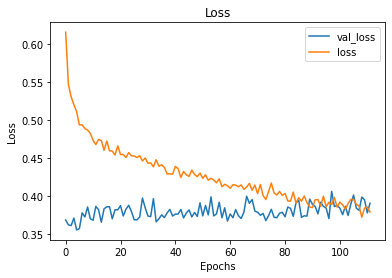

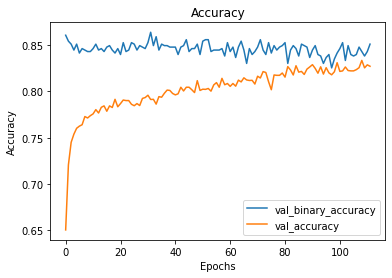

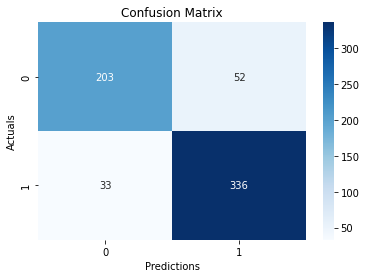

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       255
           1       0.87      0.91      0.89       369

    accuracy                           0.86       624
   macro avg       0.86      0.85      0.86       624
weighted avg       0.86      0.86      0.86       624



Evaluating the Performance:
Test Loss: 0.3727961778640747
Test Accuracy: 0.8637820482254028


In [43]:
visualize_training_results(results_3, pretrained_cnn, cnn_test_images, cnn_test_labels)